## Feature Engineering_Volatility

## Features

- Bollinger bands
- Realised semi-variance
- Realised volatility
- Realised bipower variation
- Jump variation

In [ ]:

 Realized Kernel

 Spot Volatility
 Average Spot Volatility

__Load data__

__Data Source:__ lob_sample_data.parquet

In [2]:
import pandas as pd

df = pd.read_parquet('lob_sample_data.parquet', engine='pyarrow')

In [3]:
df.head()

,Timestamp,Exchange,Bid,Ask,Date,Mid_Price
0,0.000,Exch0,[],[],2025-01-02,NaN
1,0.279,Exch0,"[[1, 6]]",[],2025-01-02,NaN
2,1.333,Exch0,"[[1, 6]]","[[800, 1]]",2025-01-02,400.5
3,1.581,Exch0,"[[1, 6]]","[[799, 1]]",2025-01-02,400.0
4,1.643,Exch0,"[[1, 6]]","[[798, 1]]",2025-01-02,399.5


In [4]:
import ast

#convert string to lists
df['Bid'] = df['Bid'].apply(ast.literal_eval)
df['Ask'] = df['Ask'].apply(ast.literal_eval)

In [5]:
#drop missing rows in mid price
df = df.dropna(subset=['Mid_Price'])

__Bollinger Bands__

- Bollinger Bands- moveing average calc over specified period e.g. 20 days. + bands for moving average + or - 2 Standard deviations. (Could be 1.5 or 2.5) 1.9-2.2 is usual for algorithmic trading. Identify volatility and potential trend reversals. When prices are near the upper band the asset may be overbought indicating a possible reversal or pullback. When prices are near the lower band- asset may be oversold suggesting a upward reversal.

In [6]:
#bollinger bands
MA = df['Mid_Price'].rolling(window=20).mean() #over 20 periods
SD = df['Mid_Price'].rolling(window=20).std()

df['Upper_BB'] = MA + (2 * SD) #upper bb
df['Lower_BB'] = MA - (2 * SD) #lower bb

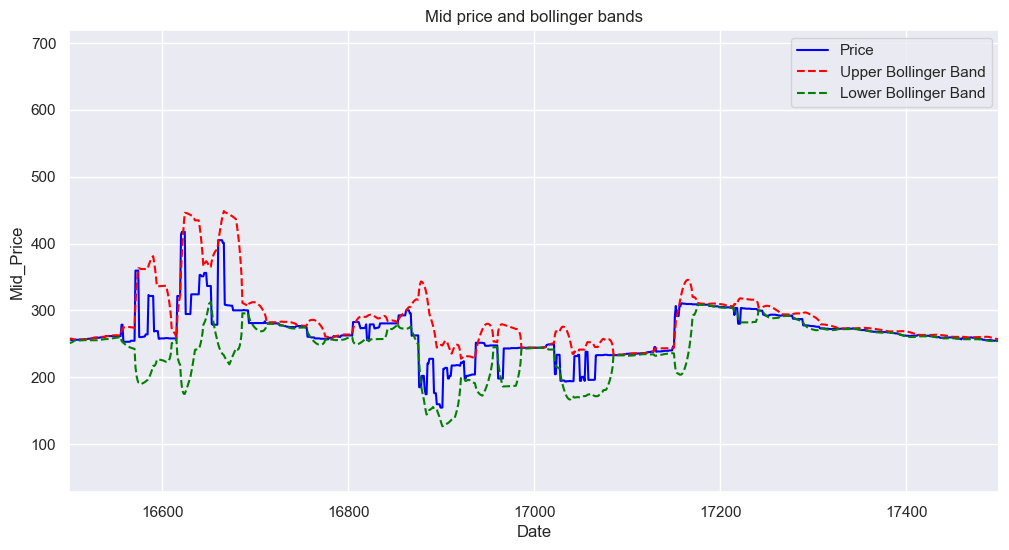

In [7]:
#plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['Mid_Price'], label='Price', color='blue')
plt.plot(df.index, df['Upper_BB'], label='Upper Bollinger Band', linestyle='--', color='red')
plt.plot(df.index, df['Lower_BB'], label='Lower Bollinger Band', linestyle='--', color='green')

#truncate to see pattern
start_index = 16500  
end_index = 17500  
plt.xlim(start_index, end_index)

plt.xlabel('Date')
plt.ylabel('Mid_Price')
plt.title('Mid price and bollinger bands')
plt.legend()

plt.show()

__Realised semi variance__

Realised semi-variance is a measure of the downside risk of an asset's returns. It's similar to realised variance but considers only the returns that fall below a certain threshold (typically, returns less than zero, focusing on negative returns). Realised semi-variance provides insight into the volatility resulting from negative market movements, which is useful for risk management purposes.

Calculated by-

$$
\text{Realised Semi-Variance} = \sum_{i=1}^{n} \min(r_i, 0)^2
$$

where $r_i$ represents the log return at interval $i$, and $n$ is the total number of intervals.

I will need to create this over a rolling window so it can apture how downside volatility changing over time. 

In [8]:
import numpy as np
import pandas as pd

#calc log returns (natural log of ratio of its final price to its initial price)
df['Log_Returns'] = np.log(df['Mid_Price'] / df['Mid_Price'].shift(1))

#define window size 
window_size = 20 #choosing 20 to be consistent with bollinger bands 

#calculate realised semi-variance for each window
df['Realised_Semi_Variance'] = df['Log_Returns'].rolling(window=window_size, min_periods=1).apply(lambda x: np.sum(
    np.minimum(x, 0)**2), raw=True)

In [9]:
nan_count = df['Log_Returns'].isna().sum()

print(f"Number of NaN values in 'Log_Returns': {nan_count}")

Number of NaN values in 'Log_Returns': 1


In [10]:
df = df.dropna(subset=['Log_Returns'])

__Realised volatility__

Realised volatility measures the variation in prices over a period and is a common measure of financial market volatility. For a rolling window calculation, we use log returns and square them to represent variance, which underpins volatility. The realised volatility over the rolling window is the square root of the rolling sum of squared log returns

This calculation provides a dynamic measure of volatility that updates over time, capturing the changing risk profile of the asset.

In [11]:
#def rolling window
window_size = 20

#calc squared log returns
df['Squared_Log_Returns'] = df['Log_Returns'] ** 2

#calc rolling realised volatility
df['Realised_Volatility'] = np.sqrt(df['Squared_Log_Returns'].rolling(window=window_size).sum())

C:\Users\s_sta\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
print((df['Squared_Log_Returns'] < 0).sum())

0


__Realised bipower variation__

Realised bipower variation is a measure used to estimate the variance of financial asset returns, focusing specifically on the continuous component of price movements and excluding jumps. It is particularly useful in high-frequency finance for analysing volatility under normal market conditions. Calculated as-

$$
RBV = \frac{\pi}{2} \cdot \sum_{i=1}^{n-1} |r_i| \cdot |r_{i+1}|
$$

where:
- $|r_i|$ is the absolute value of the log return at interval $i$,
- $n$ is the total number of log returns in the series.

RBV isolates the continuous part of price movements by leveraging the properties of bipower measures, which provides us with a robust estimate of volatility that excludes large, discontinuous jumps.

In [13]:
import numpy as np
import pandas as pd

#calc absolute log returns
df['Abs_Log_Returns'] = df['Log_Returns'].abs()

#calc realised bipower variation
#using .shift(-1) to get r_{i+1} for each r_i, multiplying adjacent abs returns
df['Realised_Bipower_Variation'] = (np.pi / 2) * (df['Abs_Log_Returns'] * df['Abs_Log_Returns'].shift(
    -1)).rolling(window=2).sum()

__Jump Variation__

Jump variation is a measure used to isolate the discontinuous (jump) components in asset prices, distinguishing them from the continuous components typically captured by other volatility measures. This distinction is particularly relevant in financial markets where sudden price movements can have significant implications.


**Total quadratic variation** ($TQV$) encompasses both continuous movements and jumps in the asset's price. It is calculated as the sum of squared log returns over a specific period.

$$TQV = \sum_{i=1}^{n} r_i^2$$
   where $r_i$ is the log return at interval $i$.


**Realised bipower variation** ($RBV$) estimates the continuous component of price movements, excluding jumps, by considering the product of absolute log returns for adjacent periods.

$RBV = \frac{\pi}{2} \cdot \sum_{i=1}^{n-1} |r_i| \cdot |r_{i+1}|$$

This uses adjacent pairs of absolute log returns to approximate the continuous component of volatility.

**Realised bipower variation** ($JV$) isolates the jump component by subtracting the continuous component ($RBV$) from the total variation ($TQV$).

$$JV = TQV - RBV$$

In [14]:
#squared log returns already calculated

#calc total quadratic variation as the sum of squared log returns
df['Total_Quadratic_Variation'] = df['Squared_Log_Returns'].rolling(window=20).sum()

#calc jump variation
df['Jump_Variation'] = df['Total_Quadratic_Variation'] - df['Realised_Bipower_Variation']